In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
import keras_tuner as kt

In [7]:
df = pd.read_csv('FuelDescriptors.csv')
print(df.shape)
df.head()

(380, 125)


,ID,Fuel,SMILES,BP(K),Pcrit(Mpa),Tcrit(K),TP_ratio,DensityCrit-kg/m3,Class,Molecular Formula,...,PEOE_VSA6,PEOE_VSA7,AMW,GRAVH,HOMO,LUMO,DM,CP,H,EI
0,1,"2,2,3-trimethylpentane",CCC(C)C(C)(C)C,382.965,2.72779,563.462,206.563555,257.091,Hydrocarbons,C8H18,...,41.039508,11.332897,4.390033,1130.293791,-0.293138,0.077285,0.036056,-0.107936,0.370421,0.015726
1,2,cis-2-hexene,C/C=C\CCC,342.043,3.23719,513.400,158.594336,237.587,Hydrocarbons,C6H12,...,25.496599,13.344559,4.671883,693.113054,-0.293147,0.077274,0.036267,-0.099799,0.268818,0.018525
2,3,hexanenitrile,CCCCCC#N,436.589,3.29888,633.758,192.113081,254.448,Nitriles,C6H11N,...,19.765380,6.420822,5.393842,846.876830,-0.234208,0.034610,0.173723,-0.138620,0.352123,0.027285
3,4,N-nonadecane,CCCCCCCCCCCCCCCCCCC,603.138,1.15966,755.761,651.709122,221.116,Hydrocarbons,C19H40,...,123.001442,0.000000,4.547678,3022.763047,-0.314681,0.037442,4.220870,-0.108166,0.361874,0.016166
4,5,"1,3-cyclopentadiene",C1C=CC=C1,313.337,4.90824,501.000,102.073248,289.851,Hydrocarbons,C5H6,...,24.304080,6.420822,6.004268,601.995661,-0.289103,0.072771,0.083924,-0.110684,0.201720,0.030366


In [8]:
def get_ranges(df):
    """helper function for plotting """
    #first col: BP
    #second col: Pcrit
    #third col: Tcrit
    #fourth col: Density
    #min is 3rd index row, max is is 7th index row
    info = df.describe()
    BP_min = info.iloc[3,0]
    BP_max = info.iloc[-1,0]
    Pcrit_min = info.iloc[3,1]
    Pcrit_max = info.iloc[-1,1]
    Tcrit_min = info.iloc[3,2]
    Tcrit_max = info.iloc[-1,2]
    rho_min = info.iloc[3,3]
    rho_max = info.iloc[-1,3]
    my_dict= {'BMIN': round(BP_min), 'BMAX': round(BP_max),
              'PMIN': round(Pcrit_min),'PMAX':round(Pcrit_max),
              'TMIN':round(Tcrit_min),'TMAX':round(Tcrit_max),
              'DMIN':round(rho_min), 'DMAX':round(rho_max)}
    return my_dict

only_targets = df.iloc[:,[3,4,5,7]]
ranges = get_ranges(only_targets)
print(ranges)

{'BMIN': 112, 'BMAX': 656, 'PMIN': 1, 'PMAX': 8, 'TMIN': 191, 'TMAX': 828, 'DMIN': 163, 'DMAX': 518}


In [9]:
def PCA_keep_dim(x):
    # performing preprocessing part
    sc = StandardScaler()
    x_all = sc.fit_transform(x)
    
    #perform PCA without reducing the dimensionality
    pca = PCA() #define PCA model to use
    pca.fit(x_all)#fit PCA model to data
    cumsum = np.cumsum(pca.explained_variance_ratio_)  #Cumulative proportion of variance (from PC1 to PC115),shape:(115,)
    #num_PCs = cumsum.shape[0] #number of principal components
    num_PCs = pca.n_components_
    PC_values = np.arange(pca.n_components_) + 1
    
    #plot cumulative explained variance ratio as a function of the number of components:
    fig = plt.figure(figsize=(8,5))
    plt.plot(PC_values, cumsum, linewidth=2, color = 'blue')
    plt.title('Cumulative Variation Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()
    plt.savefig('CumulativeVar.png')
    
    #Generate scree plot
    #Scree plot: calculate the percentage of total variance explained by each principal component 
    fig2 = plt.figure(figsize=(8,5))
    plt.plot(PC_values, pca.explained_variance_ratio_, linewidth=2, color='blue')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Explained Variance')
    plt.grid()
    plt.show()

# Plot cumulative variation to determine the appropriate number of principal components to use for dimensionality reduction

(380, 115)


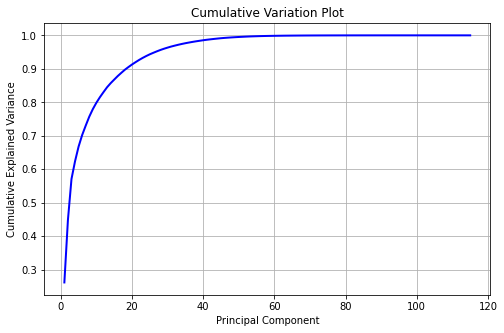

<Figure size 432x288 with 0 Axes>

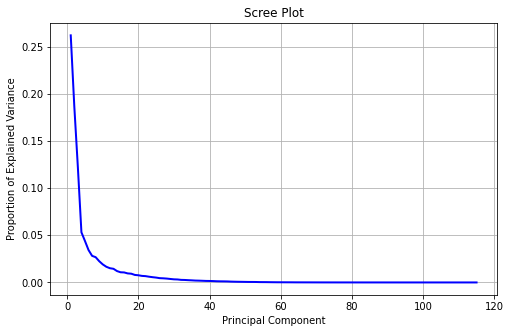

In [10]:
x = df[df.columns[10:]].values #features/predictors
print(x.shape)
PCA_keep_dim(x)

In [11]:
classes = df['Class'] #this is to make sure that all classes are represented equally in your train and test
classes

0      Hydrocarbons
1      Hydrocarbons
2          Nitriles
3      Hydrocarbons
4      Hydrocarbons
           ...     
375        Nitriles
376        Nitriles
377        Nitriles
378        Nitriles
379        Nitriles
Name: Class, Length: 380, dtype: object

In [12]:
df.head()

,ID,Fuel,SMILES,BP(K),Pcrit(Mpa),Tcrit(K),TP_ratio,DensityCrit-kg/m3,Class,Molecular Formula,...,PEOE_VSA6,PEOE_VSA7,AMW,GRAVH,HOMO,LUMO,DM,CP,H,EI
0,1,"2,2,3-trimethylpentane",CCC(C)C(C)(C)C,382.965,2.72779,563.462,206.563555,257.091,Hydrocarbons,C8H18,...,41.039508,11.332897,4.390033,1130.293791,-0.293138,0.077285,0.036056,-0.107936,0.370421,0.015726
1,2,cis-2-hexene,C/C=C\CCC,342.043,3.23719,513.400,158.594336,237.587,Hydrocarbons,C6H12,...,25.496599,13.344559,4.671883,693.113054,-0.293147,0.077274,0.036267,-0.099799,0.268818,0.018525
2,3,hexanenitrile,CCCCCC#N,436.589,3.29888,633.758,192.113081,254.448,Nitriles,C6H11N,...,19.765380,6.420822,5.393842,846.876830,-0.234208,0.034610,0.173723,-0.138620,0.352123,0.027285
3,4,N-nonadecane,CCCCCCCCCCCCCCCCCCC,603.138,1.15966,755.761,651.709122,221.116,Hydrocarbons,C19H40,...,123.001442,0.000000,4.547678,3022.763047,-0.314681,0.037442,4.220870,-0.108166,0.361874,0.016166
4,5,"1,3-cyclopentadiene",C1C=CC=C1,313.337,4.90824,501.000,102.073248,289.851,Hydrocarbons,C5H6,...,24.304080,6.420822,6.004268,601.995661,-0.289103,0.072771,0.083924,-0.110684,0.201720,0.030366


In [13]:
df2 = df.drop(['ID','Fuel','SMILES','Class','Molecular Formula'],axis = 1)
df2

,BP(K),Pcrit(Mpa),Tcrit(K),TP_ratio,DensityCrit-kg/m3,N_Atoms,Molecular Weight (g/mol),Wiener,Z1,BalabanJ,...,PEOE_VSA6,PEOE_VSA7,AMW,GRAVH,HOMO,LUMO,DM,CP,H,EI
0,382.965,2.72779,563.462,206.563555,257.091,26,114.232,63,34,3.623281,...,41.039508,11.332897,4.390033,1130.293791,-0.293138,0.077285,0.036056,-0.107936,0.370421,0.015726
1,342.043,3.23719,513.400,158.594336,237.587,18,84.162,35,18,2.339092,...,25.496599,13.344559,4.671883,693.113054,-0.293147,0.077274,0.036267,-0.099799,0.268818,0.018525
2,436.589,3.29888,633.758,192.113081,254.448,18,97.161,56,22,2.447473,...,19.765380,6.420822,5.393842,846.876830,-0.234208,0.034610,0.173723,-0.138620,0.352123,0.027285
3,603.138,1.15966,755.761,651.709122,221.116,59,268.529,1140,70,2.876697,...,123.001442,0.000000,4.547678,3022.763047,-0.314681,0.037442,4.220870,-0.108166,0.361874,0.016166
4,313.337,4.90824,501.000,102.073248,289.851,11,66.103,15,20,2.083333,...,24.304080,6.420822,6.004268,601.995661,-0.289103,0.072771,0.083924,-0.110684,0.201720,0.030366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,414.353,3.58035,610.260,170.447023,257.491,15,83.134,35,18,2.339092,...,13.344559,6.420822,5.538233,698.463187,-0.316900,0.033018,3.874961,-0.141941,0.349918,0.028788
376,457.321,3.12394,657.000,210.311338,255.282,21,111.188,84,26,2.530060,...,26.186202,6.420822,5.290705,1023.498335,-0.316017,0.033828,3.843514,-0.141094,0.349845,0.028452
377,549.197,2.13956,746.000,348.669820,237.126,36,181.323,364,46,2.758150,...,58.290310,6.420822,5.032862,1848.907130,-0.301011,0.034123,3.808787,-0.133444,0.335134,0.026567
378,583.107,2.34399,744.000,317.407497,248.377,28,164.252,286,42,2.727243,...,25.683286,12.841643,5.861834,1676.203118,-0.318405,0.030227,6.229081,-0.144089,0.348632,0.029776


# Use 80/10/10 split to create training,validation, and test subsets.
## The first split is a stratified split

In [14]:
x0 = df2[df2.columns[5:]]
x = np.asarray(x0).astype(np.float32)
y0 = df2[df2.columns[0:5]]
y = np.asarray(y0).astype(np.float32)
print(x.shape, y.shape)# number of input features and number of output features

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.10, random_state=1,stratify=classes)

x_train, x_val, y_train, y_val  = train_test_split(x_train, y_train,
                                                   test_size=0.10, random_state=1)

(380, 115) (380, 5)


In [15]:
print('Full dataset: ',x.shape,y.shape)
print('Training: ',x_train.shape,y_train.shape)
print('Validation: ',x_val.shape,y_val.shape)
print('Test: ',x_test.shape,y_test.shape)

Full dataset:  (380, 115) (380, 5)
Training:  (307, 115) (307, 5)
Validation:  (35, 115) (35, 5)
Test:  (38, 115) (38, 5)


# Standardize features before applying PCA

In [16]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

print(x_train.shape[1])
print(y_train.shape[1])

115
5


In [17]:
# Applying PCA function on training,validation and testing set of X component
from sklearn.decomposition import PCA
  
pca = PCA(n_components = 40)
  
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
x_val = pca.transform(x_val)
  
#explained_variance = pca.explained_variance_ratio_
#cumsum = pca.explained_variance_ratio_.cumsum()

# Use KerasTuner with RandomSearch to find the optimal hyperparameters of the ANN

In [17]:
def build_model(hp):
    model = tf.keras.Sequential()
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    kernel_init = hp.Choice('kernel_init', ['he_uniform','normal','he_normal'])
    l1_reg = hp.Choice('l1',[0.1,0.01, 0.001, 0.0001])
    l2_reg = hp.Choice('l2',[0.1,0.01, 0.001, 0.0001])
    
    model.add(Dense(units=hp_units1,kernel_initializer=kernel_init,
                    kernel_regularizer=keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                    activation='relu',input_shape=(x_train.shape[1],)))
    
    model.add(tf.keras.layers.Dense(units=hp_units2,kernel_initializer=kernel_init,
                                    kernel_regularizer=keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                                    activation='relu'))
    #model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))
    drop_rate = hp.Float("drop_rate", min_value=0.05, max_value=0.50, step=0.10)
    model.add(tf.keras.layers.Dropout(drop_rate))
    
    
    model.add(Dense(y_train.shape[1], kernel_initializer=kernel_init, activation='linear'))
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss= tf.keras.losses.MeanAbsoluteError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

tuner = kt.RandomSearch(
    hypermodel=build_model,
    # The objective name and direction.
    # Name is the f"val_{snake_case_metric_class_name}".
    objective=kt.Objective("val_root_mean_squared_error", direction="min"),
    max_trials=3,
    overwrite=True,
    directory="my_dir2",
    project_name="ANN_QSPR",
)

# Display the 10 best trials after the search has concluded

In [18]:
tuner.search(x_train, y_train, epochs=1000, batch_size=64, validation_data=(x_val,y_val))

tuner.results_summary()

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 3 Complete [00h 03m 49s]
val_root_mean_squared_error: 13.300226211547852

Best val_root_mean_squared_error So Far: 13.300226211547852
Total elapsed time: 00h 15m 02s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir2/ANN_QSPR
Showing 10 best trials
Objective(name='val_root_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
units1: 192
units2: 384
kernel_init: he_normal
l1: 0.0001
l2: 0.1
drop_rate: 0.15000000000000002
learning_rate: 0.0032414632197183516
Score: 13.300226211547852
Trial summary
Hyperparameters:
units1: 448
units2: 160
kernel_init: normal
l1: 0.0001
l2: 0.1
drop_rate: 0.25000000000000006
learning_rate: 0.0005618333446427555
Score: 17.14590072631836
Trial summary
Hyperparameters:
units1: 64
units2: 256
kernel_init: normal
l1: 0.1
l2: 0.1
drop_rate: 0.15000000000000002
learning_rate: 0.0007358058711559769
Score: 23.953386306762695


# Optimal hyperparameters found by KerasTuner

In [20]:
for h_param in [f"units{i}" for i in range(1,3)] + ['learning_rate'] + ['kernel_init'] + ['drop_rate'] +['l1']+['l2']:
    print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 192
units2 384
learning_rate 0.0032414632197183516
kernel_init he_normal
drop_rate 0.15000000000000002
l1 0.0001
l2 0.1


# Build the model with the optimal hyperparameters and train it on the data for 1000 epochs

In [21]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_val,y_val))

Epoch 1/1000
10/10 [==============================] - 1s 51ms/step - loss: 396.8732 - root_mean_squared_error: 358.1993 - val_loss: 352.9082 - val_root_mean_squared_error: 338.5111
Epoch 2/1000
10/10 [==============================] - 0s 22ms/step - loss: 328.3569 - root_mean_squared_error: 317.9619 - val_loss: 262.1747 - val_root_mean_squared_error: 259.9040
Epoch 3/1000
10/10 [==============================] - 0s 16ms/step - loss: 228.8031 - root_mean_squared_error: 223.0854 - val_loss: 175.4319 - val_root_mean_squared_error: 166.9020
Epoch 4/1000
10/10 [==============================] - 0s 22ms/step - loss: 157.2762 - root_mean_squared_error: 136.2341 - val_loss: 120.2258 - val_root_mean_squared_error: 102.6172
Epoch 5/1000
10/10 [==============================] - 0s 27ms/step - loss: 110.6216 - root_mean_squared_error: 79.1779 - val_loss: 93.9078 - val_root_mean_squared_error: 70.3003
Epoch 6/1000
10/10 [==============================] - 0s 24ms/step - loss: 87.2800 - root_mean_squ

Epoch 47/1000
10/10 [==============================] - 0s 24ms/step - loss: 25.5332 - root_mean_squared_error: 19.0891 - val_loss: 28.2537 - val_root_mean_squared_error: 25.5881
Epoch 48/1000
10/10 [==============================] - 0s 20ms/step - loss: 27.2395 - root_mean_squared_error: 22.2461 - val_loss: 28.1548 - val_root_mean_squared_error: 24.0139
Epoch 49/1000
10/10 [==============================] - 0s 22ms/step - loss: 26.5000 - root_mean_squared_error: 20.3155 - val_loss: 29.7181 - val_root_mean_squared_error: 29.8218
Epoch 50/1000
10/10 [==============================] - 0s 28ms/step - loss: 27.2273 - root_mean_squared_error: 21.8382 - val_loss: 26.7070 - val_root_mean_squared_error: 23.6190
Epoch 51/1000
10/10 [==============================] - 0s 30ms/step - loss: 24.5941 - root_mean_squared_error: 19.3894 - val_loss: 25.3906 - val_root_mean_squared_error: 21.6066
Epoch 52/1000
10/10 [==============================] - 0s 20ms/step - loss: 24.3113 - root_mean_squared_error:

10/10 [==============================] - 0s 21ms/step - loss: 23.4693 - root_mean_squared_error: 22.1628 - val_loss: 19.2059 - val_root_mean_squared_error: 17.8002
Epoch 94/1000
10/10 [==============================] - 0s 21ms/step - loss: 20.4806 - root_mean_squared_error: 19.0956 - val_loss: 25.3072 - val_root_mean_squared_error: 27.5572
Epoch 95/1000
10/10 [==============================] - 0s 21ms/step - loss: 20.8908 - root_mean_squared_error: 20.0216 - val_loss: 20.8305 - val_root_mean_squared_error: 20.3321
Epoch 96/1000
10/10 [==============================] - 0s 22ms/step - loss: 20.2683 - root_mean_squared_error: 19.3309 - val_loss: 21.6858 - val_root_mean_squared_error: 20.6907
Epoch 97/1000
10/10 [==============================] - 0s 21ms/step - loss: 19.4939 - root_mean_squared_error: 17.6659 - val_loss: 18.4369 - val_root_mean_squared_error: 17.5092
Epoch 98/1000
10/10 [==============================] - 0s 22ms/step - loss: 19.1937 - root_mean_squared_error: 17.2871 - val

Epoch 139/1000
10/10 [==============================] - 0s 26ms/step - loss: 17.8348 - root_mean_squared_error: 17.3942 - val_loss: 18.0553 - val_root_mean_squared_error: 18.3465
Epoch 140/1000
10/10 [==============================] - 0s 21ms/step - loss: 16.6905 - root_mean_squared_error: 16.5387 - val_loss: 17.9531 - val_root_mean_squared_error: 19.6721
Epoch 141/1000
10/10 [==============================] - 0s 31ms/step - loss: 16.9623 - root_mean_squared_error: 16.7167 - val_loss: 17.4556 - val_root_mean_squared_error: 19.4848
Epoch 142/1000
10/10 [==============================] - 0s 25ms/step - loss: 17.8674 - root_mean_squared_error: 18.6256 - val_loss: 16.6183 - val_root_mean_squared_error: 17.8449
Epoch 143/1000
10/10 [==============================] - 0s 22ms/step - loss: 16.9489 - root_mean_squared_error: 17.0362 - val_loss: 18.5852 - val_root_mean_squared_error: 20.9226
Epoch 144/1000
10/10 [==============================] - 0s 33ms/step - loss: 17.5645 - root_mean_squared_

Epoch 185/1000
10/10 [==============================] - 0s 21ms/step - loss: 16.1669 - root_mean_squared_error: 17.3766 - val_loss: 18.0147 - val_root_mean_squared_error: 19.1014
Epoch 186/1000
10/10 [==============================] - 0s 25ms/step - loss: 18.1769 - root_mean_squared_error: 19.7196 - val_loss: 14.7379 - val_root_mean_squared_error: 16.3613
Epoch 187/1000
10/10 [==============================] - 0s 23ms/step - loss: 14.9632 - root_mean_squared_error: 15.3768 - val_loss: 14.7835 - val_root_mean_squared_error: 17.0050
Epoch 188/1000
10/10 [==============================] - 0s 27ms/step - loss: 14.8812 - root_mean_squared_error: 15.3676 - val_loss: 19.0924 - val_root_mean_squared_error: 23.1275
Epoch 189/1000
10/10 [==============================] - 0s 23ms/step - loss: 17.6358 - root_mean_squared_error: 19.3941 - val_loss: 19.6925 - val_root_mean_squared_error: 24.1533
Epoch 190/1000
10/10 [==============================] - 0s 26ms/step - loss: 18.9635 - root_mean_squared_

Epoch 231/1000
10/10 [==============================] - 0s 19ms/step - loss: 14.0622 - root_mean_squared_error: 15.0859 - val_loss: 14.4909 - val_root_mean_squared_error: 18.5566
Epoch 232/1000
10/10 [==============================] - 0s 28ms/step - loss: 14.1995 - root_mean_squared_error: 16.2977 - val_loss: 12.6514 - val_root_mean_squared_error: 15.2877
Epoch 233/1000
10/10 [==============================] - 0s 22ms/step - loss: 13.6079 - root_mean_squared_error: 14.8831 - val_loss: 14.9541 - val_root_mean_squared_error: 17.4299
Epoch 234/1000
10/10 [==============================] - 0s 29ms/step - loss: 14.9480 - root_mean_squared_error: 16.5651 - val_loss: 16.6484 - val_root_mean_squared_error: 21.3476
Epoch 235/1000
10/10 [==============================] - 0s 21ms/step - loss: 15.8633 - root_mean_squared_error: 17.9926 - val_loss: 16.0570 - val_root_mean_squared_error: 18.1123
Epoch 236/1000
10/10 [==============================] - 0s 23ms/step - loss: 16.2711 - root_mean_squared_

Epoch 277/1000
10/10 [==============================] - 0s 24ms/step - loss: 14.9071 - root_mean_squared_error: 18.6459 - val_loss: 12.7954 - val_root_mean_squared_error: 17.6454
Epoch 278/1000
10/10 [==============================] - 0s 24ms/step - loss: 13.0370 - root_mean_squared_error: 14.6133 - val_loss: 14.7722 - val_root_mean_squared_error: 18.9268
Epoch 279/1000
10/10 [==============================] - 0s 25ms/step - loss: 14.9968 - root_mean_squared_error: 17.4216 - val_loss: 12.7112 - val_root_mean_squared_error: 16.3481
Epoch 280/1000
10/10 [==============================] - 0s 24ms/step - loss: 13.7386 - root_mean_squared_error: 16.4832 - val_loss: 14.9469 - val_root_mean_squared_error: 18.8098
Epoch 281/1000
10/10 [==============================] - 0s 23ms/step - loss: 14.4843 - root_mean_squared_error: 17.4824 - val_loss: 13.7493 - val_root_mean_squared_error: 16.5070
Epoch 282/1000
10/10 [==============================] - 0s 22ms/step - loss: 13.6627 - root_mean_squared_

Epoch 323/1000
10/10 [==============================] - 0s 23ms/step - loss: 13.9431 - root_mean_squared_error: 16.3219 - val_loss: 13.4516 - val_root_mean_squared_error: 17.7094
Epoch 324/1000
10/10 [==============================] - 0s 22ms/step - loss: 13.0290 - root_mean_squared_error: 14.9275 - val_loss: 13.0408 - val_root_mean_squared_error: 17.3661
Epoch 325/1000
10/10 [==============================] - 0s 27ms/step - loss: 13.2549 - root_mean_squared_error: 16.4616 - val_loss: 11.8744 - val_root_mean_squared_error: 15.2643
Epoch 326/1000
10/10 [==============================] - 0s 24ms/step - loss: 12.7797 - root_mean_squared_error: 14.9425 - val_loss: 13.3653 - val_root_mean_squared_error: 16.2168
Epoch 327/1000
10/10 [==============================] - 0s 23ms/step - loss: 13.1441 - root_mean_squared_error: 15.2757 - val_loss: 14.0955 - val_root_mean_squared_error: 19.0729
Epoch 328/1000
10/10 [==============================] - 0s 21ms/step - loss: 14.0880 - root_mean_squared_

Epoch 369/1000
10/10 [==============================] - 0s 20ms/step - loss: 13.0591 - root_mean_squared_error: 15.4566 - val_loss: 14.2634 - val_root_mean_squared_error: 19.3772
Epoch 370/1000
10/10 [==============================] - 0s 20ms/step - loss: 14.2111 - root_mean_squared_error: 17.1573 - val_loss: 12.5696 - val_root_mean_squared_error: 15.9092
Epoch 371/1000
10/10 [==============================] - 0s 21ms/step - loss: 13.9573 - root_mean_squared_error: 16.9055 - val_loss: 14.7970 - val_root_mean_squared_error: 20.0106
Epoch 372/1000
10/10 [==============================] - 0s 22ms/step - loss: 15.1059 - root_mean_squared_error: 19.4150 - val_loss: 11.5448 - val_root_mean_squared_error: 15.9005
Epoch 373/1000
10/10 [==============================] - 0s 25ms/step - loss: 13.3769 - root_mean_squared_error: 17.3055 - val_loss: 13.7282 - val_root_mean_squared_error: 17.2007
Epoch 374/1000
10/10 [==============================] - 0s 22ms/step - loss: 13.3360 - root_mean_squared_

Epoch 415/1000
10/10 [==============================] - 0s 24ms/step - loss: 14.3312 - root_mean_squared_error: 17.4781 - val_loss: 14.3029 - val_root_mean_squared_error: 17.6083
Epoch 416/1000
10/10 [==============================] - 0s 27ms/step - loss: 14.3852 - root_mean_squared_error: 18.2264 - val_loss: 13.1744 - val_root_mean_squared_error: 18.6316
Epoch 417/1000
10/10 [==============================] - 0s 23ms/step - loss: 12.9470 - root_mean_squared_error: 15.7076 - val_loss: 12.1287 - val_root_mean_squared_error: 16.5961
Epoch 418/1000
10/10 [==============================] - 0s 20ms/step - loss: 13.4020 - root_mean_squared_error: 16.2692 - val_loss: 11.7630 - val_root_mean_squared_error: 14.4536
Epoch 419/1000
10/10 [==============================] - 0s 19ms/step - loss: 12.1216 - root_mean_squared_error: 14.7250 - val_loss: 12.7567 - val_root_mean_squared_error: 16.4817
Epoch 420/1000
10/10 [==============================] - 0s 21ms/step - loss: 12.8922 - root_mean_squared_

Epoch 461/1000
10/10 [==============================] - 0s 21ms/step - loss: 12.3946 - root_mean_squared_error: 15.6928 - val_loss: 14.9539 - val_root_mean_squared_error: 19.2066
Epoch 462/1000
10/10 [==============================] - 0s 21ms/step - loss: 12.5823 - root_mean_squared_error: 15.9890 - val_loss: 12.0656 - val_root_mean_squared_error: 15.9514
Epoch 463/1000
10/10 [==============================] - 0s 24ms/step - loss: 12.7407 - root_mean_squared_error: 15.3209 - val_loss: 12.1309 - val_root_mean_squared_error: 15.5331
Epoch 464/1000
10/10 [==============================] - 0s 23ms/step - loss: 12.2556 - root_mean_squared_error: 15.5808 - val_loss: 11.8911 - val_root_mean_squared_error: 14.5524
Epoch 465/1000
10/10 [==============================] - 0s 21ms/step - loss: 12.8106 - root_mean_squared_error: 15.7358 - val_loss: 12.2435 - val_root_mean_squared_error: 16.6679
Epoch 466/1000
10/10 [==============================] - 0s 20ms/step - loss: 13.0178 - root_mean_squared_

Epoch 507/1000
10/10 [==============================] - 0s 16ms/step - loss: 12.4267 - root_mean_squared_error: 15.2246 - val_loss: 11.1826 - val_root_mean_squared_error: 14.8308
Epoch 508/1000
10/10 [==============================] - 0s 22ms/step - loss: 11.4417 - root_mean_squared_error: 13.9742 - val_loss: 10.9699 - val_root_mean_squared_error: 14.9240
Epoch 509/1000
10/10 [==============================] - 0s 14ms/step - loss: 12.5029 - root_mean_squared_error: 15.4926 - val_loss: 11.4193 - val_root_mean_squared_error: 13.6374
Epoch 510/1000
10/10 [==============================] - 0s 23ms/step - loss: 11.8410 - root_mean_squared_error: 14.5503 - val_loss: 11.6411 - val_root_mean_squared_error: 14.9737
Epoch 511/1000
10/10 [==============================] - 0s 23ms/step - loss: 12.0328 - root_mean_squared_error: 15.1374 - val_loss: 11.6296 - val_root_mean_squared_error: 15.2539
Epoch 512/1000
10/10 [==============================] - 0s 21ms/step - loss: 13.0112 - root_mean_squared_

Epoch 553/1000
10/10 [==============================] - 0s 20ms/step - loss: 11.9413 - root_mean_squared_error: 14.5314 - val_loss: 10.4774 - val_root_mean_squared_error: 13.9704
Epoch 554/1000
10/10 [==============================] - 0s 22ms/step - loss: 11.7510 - root_mean_squared_error: 14.9340 - val_loss: 10.8167 - val_root_mean_squared_error: 14.3921
Epoch 555/1000
10/10 [==============================] - 0s 29ms/step - loss: 11.7013 - root_mean_squared_error: 14.3655 - val_loss: 10.8129 - val_root_mean_squared_error: 14.8020
Epoch 556/1000
10/10 [==============================] - 0s 30ms/step - loss: 11.6884 - root_mean_squared_error: 14.0423 - val_loss: 11.4470 - val_root_mean_squared_error: 16.0523
Epoch 557/1000
10/10 [==============================] - 0s 17ms/step - loss: 11.4707 - root_mean_squared_error: 14.0618 - val_loss: 11.1363 - val_root_mean_squared_error: 15.7758
Epoch 558/1000
10/10 [==============================] - 0s 19ms/step - loss: 11.1611 - root_mean_squared_

Epoch 599/1000
10/10 [==============================] - 0s 26ms/step - loss: 12.7093 - root_mean_squared_error: 15.8199 - val_loss: 11.5569 - val_root_mean_squared_error: 14.7786
Epoch 600/1000
10/10 [==============================] - 0s 20ms/step - loss: 12.1989 - root_mean_squared_error: 14.7681 - val_loss: 13.0884 - val_root_mean_squared_error: 17.3710
Epoch 601/1000
10/10 [==============================] - 0s 21ms/step - loss: 12.6897 - root_mean_squared_error: 16.5420 - val_loss: 11.5129 - val_root_mean_squared_error: 15.4515
Epoch 602/1000
10/10 [==============================] - 0s 22ms/step - loss: 12.1566 - root_mean_squared_error: 15.2495 - val_loss: 15.4057 - val_root_mean_squared_error: 20.4772
Epoch 603/1000
10/10 [==============================] - 0s 21ms/step - loss: 13.7612 - root_mean_squared_error: 17.2319 - val_loss: 11.3777 - val_root_mean_squared_error: 14.9210
Epoch 604/1000
10/10 [==============================] - 0s 22ms/step - loss: 12.7512 - root_mean_squared_

Epoch 645/1000
10/10 [==============================] - 0s 22ms/step - loss: 11.8833 - root_mean_squared_error: 15.7158 - val_loss: 11.5977 - val_root_mean_squared_error: 15.7678
Epoch 646/1000
10/10 [==============================] - 0s 23ms/step - loss: 11.5791 - root_mean_squared_error: 14.6418 - val_loss: 10.7631 - val_root_mean_squared_error: 14.6043
Epoch 647/1000
10/10 [==============================] - 0s 22ms/step - loss: 11.9059 - root_mean_squared_error: 15.1484 - val_loss: 10.9319 - val_root_mean_squared_error: 14.7638
Epoch 648/1000
10/10 [==============================] - 0s 20ms/step - loss: 10.9610 - root_mean_squared_error: 13.6715 - val_loss: 11.1220 - val_root_mean_squared_error: 15.8833
Epoch 649/1000
10/10 [==============================] - 0s 27ms/step - loss: 11.8656 - root_mean_squared_error: 14.6615 - val_loss: 11.2858 - val_root_mean_squared_error: 15.2511
Epoch 650/1000
10/10 [==============================] - 0s 22ms/step - loss: 12.0964 - root_mean_squared_

Epoch 691/1000
10/10 [==============================] - 0s 20ms/step - loss: 11.4304 - root_mean_squared_error: 14.8830 - val_loss: 10.5244 - val_root_mean_squared_error: 14.3847
Epoch 692/1000
10/10 [==============================] - 0s 22ms/step - loss: 11.1449 - root_mean_squared_error: 13.8297 - val_loss: 10.9390 - val_root_mean_squared_error: 14.0618
Epoch 693/1000
10/10 [==============================] - 0s 20ms/step - loss: 11.7603 - root_mean_squared_error: 15.1930 - val_loss: 11.1929 - val_root_mean_squared_error: 15.1931
Epoch 694/1000
10/10 [==============================] - 0s 19ms/step - loss: 11.0958 - root_mean_squared_error: 14.8411 - val_loss: 10.7032 - val_root_mean_squared_error: 14.2640
Epoch 695/1000
10/10 [==============================] - 0s 21ms/step - loss: 11.4862 - root_mean_squared_error: 14.4475 - val_loss: 12.7275 - val_root_mean_squared_error: 18.2688
Epoch 696/1000
10/10 [==============================] - 0s 20ms/step - loss: 12.5149 - root_mean_squared_

Epoch 737/1000
10/10 [==============================] - 0s 28ms/step - loss: 12.2482 - root_mean_squared_error: 15.7295 - val_loss: 11.9838 - val_root_mean_squared_error: 16.3497
Epoch 738/1000
10/10 [==============================] - 0s 33ms/step - loss: 12.5728 - root_mean_squared_error: 16.5347 - val_loss: 12.2106 - val_root_mean_squared_error: 17.3539
Epoch 739/1000
10/10 [==============================] - 0s 20ms/step - loss: 12.6807 - root_mean_squared_error: 16.6594 - val_loss: 11.4452 - val_root_mean_squared_error: 16.0831
Epoch 740/1000
10/10 [==============================] - 0s 24ms/step - loss: 11.3963 - root_mean_squared_error: 14.6675 - val_loss: 10.8967 - val_root_mean_squared_error: 16.2039
Epoch 741/1000
10/10 [==============================] - 0s 24ms/step - loss: 11.2258 - root_mean_squared_error: 14.4195 - val_loss: 10.9007 - val_root_mean_squared_error: 15.7012
Epoch 742/1000
10/10 [==============================] - 0s 26ms/step - loss: 11.5360 - root_mean_squared_

Epoch 783/1000
10/10 [==============================] - 0s 24ms/step - loss: 11.1850 - root_mean_squared_error: 14.7168 - val_loss: 10.1013 - val_root_mean_squared_error: 13.6317
Epoch 784/1000
10/10 [==============================] - 0s 24ms/step - loss: 10.9603 - root_mean_squared_error: 13.8503 - val_loss: 10.4426 - val_root_mean_squared_error: 14.4784
Epoch 785/1000
10/10 [==============================] - 0s 27ms/step - loss: 11.4533 - root_mean_squared_error: 14.8097 - val_loss: 13.2115 - val_root_mean_squared_error: 19.1314
Epoch 786/1000
10/10 [==============================] - 0s 22ms/step - loss: 11.9306 - root_mean_squared_error: 15.7879 - val_loss: 11.3728 - val_root_mean_squared_error: 15.0564
Epoch 787/1000
10/10 [==============================] - 0s 23ms/step - loss: 11.7188 - root_mean_squared_error: 15.2814 - val_loss: 10.2650 - val_root_mean_squared_error: 14.4135
Epoch 788/1000
10/10 [==============================] - 0s 27ms/step - loss: 11.5450 - root_mean_squared_

Epoch 829/1000
10/10 [==============================] - 0s 24ms/step - loss: 10.3785 - root_mean_squared_error: 13.2255 - val_loss: 10.0457 - val_root_mean_squared_error: 13.6980
Epoch 830/1000
10/10 [==============================] - 0s 21ms/step - loss: 11.3875 - root_mean_squared_error: 14.3392 - val_loss: 10.7146 - val_root_mean_squared_error: 14.9842
Epoch 831/1000
10/10 [==============================] - 0s 20ms/step - loss: 11.3945 - root_mean_squared_error: 14.9291 - val_loss: 11.4326 - val_root_mean_squared_error: 15.3763
Epoch 832/1000
10/10 [==============================] - 0s 21ms/step - loss: 11.4436 - root_mean_squared_error: 15.3633 - val_loss: 10.9144 - val_root_mean_squared_error: 14.4485
Epoch 833/1000
10/10 [==============================] - 0s 20ms/step - loss: 11.4781 - root_mean_squared_error: 14.2046 - val_loss: 12.2767 - val_root_mean_squared_error: 17.6196
Epoch 834/1000
10/10 [==============================] - 0s 20ms/step - loss: 10.6994 - root_mean_squared_

Epoch 875/1000
10/10 [==============================] - 0s 22ms/step - loss: 10.8689 - root_mean_squared_error: 14.1380 - val_loss: 10.4670 - val_root_mean_squared_error: 13.8590
Epoch 876/1000
10/10 [==============================] - 0s 21ms/step - loss: 11.0013 - root_mean_squared_error: 14.3859 - val_loss: 11.6480 - val_root_mean_squared_error: 15.0665
Epoch 877/1000
10/10 [==============================] - 0s 27ms/step - loss: 11.6737 - root_mean_squared_error: 15.3509 - val_loss: 10.9943 - val_root_mean_squared_error: 14.8909
Epoch 878/1000
10/10 [==============================] - 0s 23ms/step - loss: 11.7001 - root_mean_squared_error: 15.4103 - val_loss: 10.4612 - val_root_mean_squared_error: 14.3847
Epoch 879/1000
10/10 [==============================] - 0s 23ms/step - loss: 11.8113 - root_mean_squared_error: 16.1204 - val_loss: 13.2654 - val_root_mean_squared_error: 18.0299
Epoch 880/1000
10/10 [==============================] - 0s 20ms/step - loss: 12.3994 - root_mean_squared_

Epoch 921/1000
10/10 [==============================] - 0s 20ms/step - loss: 11.3070 - root_mean_squared_error: 14.2898 - val_loss: 10.3256 - val_root_mean_squared_error: 13.9141
Epoch 922/1000
10/10 [==============================] - 0s 25ms/step - loss: 11.3688 - root_mean_squared_error: 14.8061 - val_loss: 10.0664 - val_root_mean_squared_error: 13.3524
Epoch 923/1000
10/10 [==============================] - 0s 25ms/step - loss: 11.7183 - root_mean_squared_error: 15.4002 - val_loss: 10.4003 - val_root_mean_squared_error: 13.8192
Epoch 924/1000
10/10 [==============================] - 0s 20ms/step - loss: 11.2356 - root_mean_squared_error: 14.0089 - val_loss: 11.4764 - val_root_mean_squared_error: 16.5437
Epoch 925/1000
10/10 [==============================] - 0s 20ms/step - loss: 11.3781 - root_mean_squared_error: 14.4700 - val_loss: 10.5248 - val_root_mean_squared_error: 14.2949
Epoch 926/1000
10/10 [==============================] - 0s 26ms/step - loss: 10.9570 - root_mean_squared_

Epoch 967/1000
10/10 [==============================] - 0s 21ms/step - loss: 10.7279 - root_mean_squared_error: 13.8181 - val_loss: 10.5483 - val_root_mean_squared_error: 15.1172
Epoch 968/1000
10/10 [==============================] - 0s 22ms/step - loss: 10.9684 - root_mean_squared_error: 13.6791 - val_loss: 11.0856 - val_root_mean_squared_error: 16.0564
Epoch 969/1000
10/10 [==============================] - 0s 21ms/step - loss: 10.2725 - root_mean_squared_error: 13.4966 - val_loss: 10.3898 - val_root_mean_squared_error: 14.1009
Epoch 970/1000
10/10 [==============================] - 0s 22ms/step - loss: 10.1019 - root_mean_squared_error: 12.7157 - val_loss: 10.3419 - val_root_mean_squared_error: 14.6439
Epoch 971/1000
10/10 [==============================] - 0s 23ms/step - loss: 10.8778 - root_mean_squared_error: 13.7280 - val_loss: 10.0058 - val_root_mean_squared_error: 13.5470
Epoch 972/1000
10/10 [==============================] - 0s 21ms/step - loss: 10.7320 - root_mean_squared_

In [22]:
print(history.history.keys())
print(model.summary())

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 192)               7872      
_________________________________________________________________
dense_1 (Dense)              (None, 384)               74112     
_________________________________________________________________
dropout (Dropout)            (None, 384)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1925      
Total params: 83,909
Trainable params: 83,909
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 965


In [24]:
eval_result = model.evaluate(x_test, y_test)
print("[test loss, test error]:", eval_result)

2/2 [==============================] - 0s 17ms/step - loss: 9.0938 - root_mean_squared_error: 11.6756
[test loss, test error]: [9.093782424926758, 11.675602912902832]


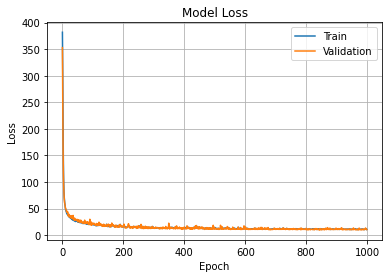

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
plt.show()

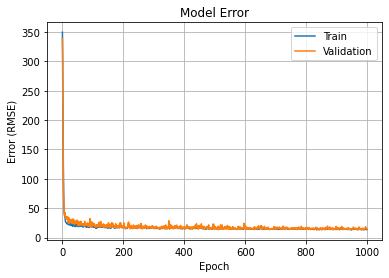

In [55]:
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Error')
plt.ylabel('Error (RMSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
plt.show()

# Create plotting functions to help assess model performance

In [118]:
def create_residuals_plot(y_train,y_train_pred,y_val,y_val_pred,y_test,y_test_pred,title,xmin,xmax):
    """Plot residuals vs predicted values"""
#     y_train_pred_copy = y_train_pred.copy()
#     y_train_pred_flat= y_train_pred_copy.flatten()
#     y_test_pred_copy = y_test_pred.copy()
#     y_test_pred_flat = y_test_pred_copy.flatten()
    
    plt.scatter(y_train_pred,
            y_train_pred- y_train,
            c= 'steelblue',
            edgecolor = 'white',
            marker = 'o',
            s = 35,
            alpha = 0.9,
            label = 'Training Data')
    
    plt.scatter(y_val_pred,
            y_val_pred- y_val,
            c= 'gold',
            edgecolor = 'white',
            marker = '^',
            s = 35,
            alpha = 0.9,
            label = 'Validation Data')

    plt.scatter(y_test_pred,
                y_test_pred - y_test,
                c = 'limegreen',
                edgecolor = 'white',
                marker = 's',
                s=35,
                alpha = 0.9,
                label = 'Test Data')

    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='best')
    plt.hlines(y=0,xmin=xmin,xmax=xmax,lw=2,color='black')
    plt.xlim([xmin,xmax])
    plt.tight_layout()
    plt.grid()
    plt.title(title)
    plt.show()
    
def create_correlation_plot(y_train,y_train_pred,y_val,y_val_pred,y_test,y_test_pred,prop,rmin,rmax):
    """Plot predicted values against experimental values"""
#     y_train_pred_copy = y_train_pred.copy()
#     y_train_pred_flat= y_train_pred_copy.flatten()
#     y_test_pred_copy = y_test_pred.copy()
#     y_test_pred_flat = y_test_pred_copy.flatten()

    plt.scatter(y_train,y_train_pred,color='blue',label='Training Data')
    plt.scatter(y_val,y_val_pred,color='gold',label='Validation Data')
    plt.scatter(y_test,y_test_pred,color='red',label='Test Data')
    plt.xlabel('Actual {}'.format(prop))
    plt.ylabel('Predicted {}'.format(prop))
    plt.legend(loc='upper left')
    plt.grid()
    #plt.title('ANN')
    plt.plot(range(rmin,rmax), range(rmin,rmax),'k')

# Overall R^2 scores for all 5 target properties

In [81]:
from sklearn.metrics import r2_score
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)
print('R^2 train: %.3f, val: %.3f, test: %.3f' %
       (r2_score(y_train,y_train_pred),
        r2_score(y_val,y_val_pred),
        r2_score(y_test, y_test_pred)))

R^2 train: 0.939, val: 0.883, test: 0.914


In [1]:
from sklearn.metrics import mean_squared_error

print('RMSE train: %.3f, val: %.3f, test: %.3f' % (
        mean_squared_error(y_train,y_train_pred,squared=False),
        mean_squared_error(y_val,y_val_pred,squared=False),
        mean_squared_error(y_test, y_test_pred,squared=False)))

NameError: name 'y_train' is not defined

# Boiling point results

In [83]:
BP_train_vals = y_train[:,0]
BP_train_pred = y_train_pred[:,0]

BP_valid_vals = y_val[:,0]
BP_valid_pred = y_val_pred[:,0]

BP_test_vals = y_test[:,0]
BP_test_pred = y_test_pred[:,0]

print('Boiling point: R^2 train: %.3f, val: %.3f, test: %.3f' %
       (r2_score(BP_train_vals,BP_train_pred),
        r2_score(BP_valid_vals,BP_valid_pred),
        r2_score(BP_test_vals,BP_test_pred)))

Boiling point: R^2 train: 0.991, val: 0.976, test: 0.986


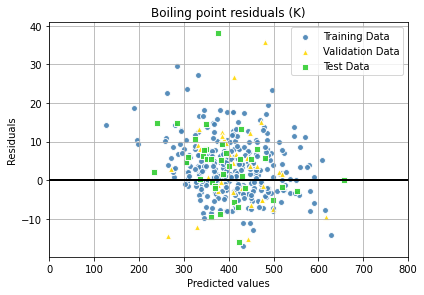

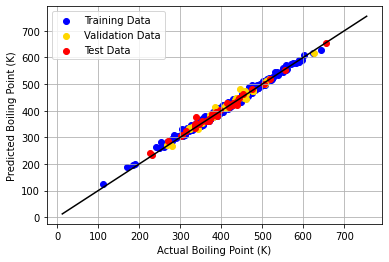

In [91]:
create_residuals_plot(BP_train_vals,BP_train_pred,
                      BP_valid_vals,BP_valid_pred,
                      BP_test_vals,BP_test_pred,'Boiling point residuals (K)',0,800)

create_correlation_plot(BP_train_vals,BP_train_pred,
                        BP_valid_vals,BP_valid_pred,
                        BP_test_vals,BP_test_pred,
                        'Boiling Point (K)', ranges['BMIN']-100,ranges['BMAX']+100)

# Critical pressure results

In [89]:
Pcrit_train_vals = y_train[:,1]
Pcrit_train_pred = y_train_pred[:,1]

Pcrit_valid_vals = y_val[:,1]
Pcrit_valid_pred = y_val_pred[:,1]

Pcrit_test_vals = y_test[:,1]
Pcrit_test_pred = y_test_pred[:,1]
    
print('Critical pressure: R^2 train: %.3f, val: %.3f, test: %.3f' %
       (r2_score(Pcrit_train_vals,Pcrit_train_pred),
        r2_score(Pcrit_valid_vals,Pcrit_valid_pred),
        r2_score(Pcrit_test_vals,Pcrit_test_pred)))

Critical pressure: R^2 train: 0.831, val: 0.763, test: 0.780


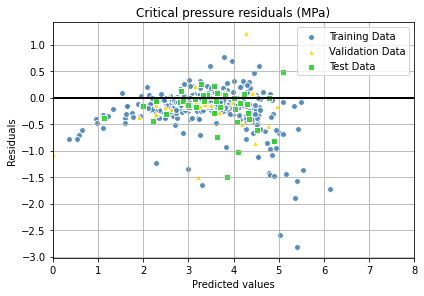

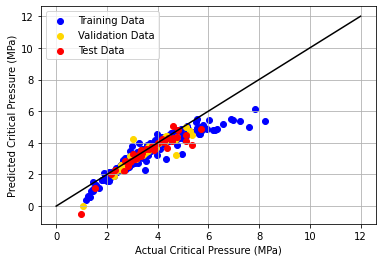

In [96]:
create_residuals_plot(Pcrit_train_vals ,Pcrit_train_pred,
                      Pcrit_valid_vals ,Pcrit_valid_pred,
                      Pcrit_test_vals ,Pcrit_test_pred,
                      'Critical pressure residuals (MPa)',0,8)

create_correlation_plot(Pcrit_train_vals ,Pcrit_train_pred,
                        Pcrit_valid_vals ,Pcrit_valid_pred,
                        Pcrit_test_vals ,Pcrit_test_pred,
                        'Critical Pressure (MPa)',ranges['PMIN']-1,ranges['PMAX']+5)

# Critical temperature results

In [97]:
Tcrit_train_vals = y_train[:,2]
Tcrit_train_pred = y_train_pred[:,2]

Tcrit_valid_vals = y_val[:,2]
Tcrit_valid_pred = y_val_pred[:,2]

Tcrit_test_vals =  y_test[:,2]
Tcrit_test_pred = y_test_pred[:,2]

print('Critical temperature: R^2 train: %.3f, val: %.3f, test: %.3f' %
       (r2_score(Tcrit_train_vals,Tcrit_train_pred),
        r2_score(Tcrit_valid_vals,Tcrit_valid_pred),
        r2_score(Tcrit_test_vals,Tcrit_test_pred)))

Critical temperature: R^2 train: 0.987, val: 0.958, test: 0.976


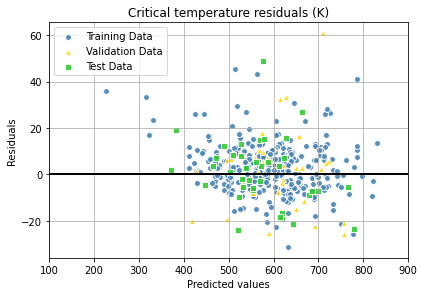

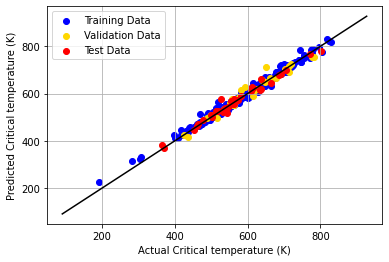

In [98]:
create_residuals_plot(Tcrit_train_vals ,Tcrit_train_pred,
                      Tcrit_valid_vals,Tcrit_valid_pred,
                      Tcrit_test_vals,Tcrit_test_pred,
                      'Critical temperature residuals (K)',100,900)

create_correlation_plot(Tcrit_train_vals ,Tcrit_train_pred,
                        Tcrit_valid_vals,Tcrit_valid_pred,
                        Tcrit_test_vals,Tcrit_test_pred,
                        'Critical temperature (K)', ranges['TMIN']-100,ranges['TMAX']+100)

# Ratio of critical temperature to critical pressure results 

In [99]:
TP_train_vals = y_train[:,3]
TP_train_pred = y_train_pred[:,3]

TP_valid_vals = y_val[:,3]
TP_valid_pred = y_val_pred[:,3]

TP_test_vals = y_test[:,3]
TP_test_pred = y_test_pred[:,3]

    
print('Tcrit/Pcrit ratio: R^2 train: %.3f, val: %.3f, test: %.3f' %
       (r2_score(TP_train_vals,TP_train_pred),
        r2_score(TP_valid_vals,TP_valid_pred),
        r2_score(TP_test_vals,TP_test_pred)))

Tcrit/Pcrit ratio: R^2 train: 0.978, val: 0.955, test: 0.987


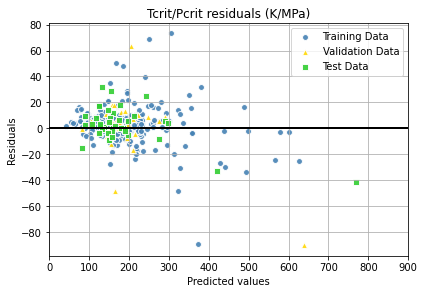

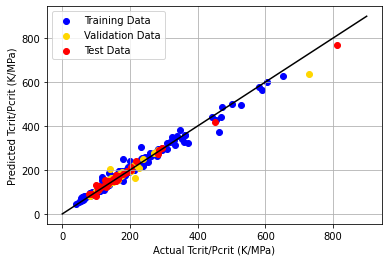

In [101]:
create_residuals_plot(TP_train_vals,TP_train_pred,
                      TP_valid_vals,TP_valid_pred,
                      TP_test_vals,TP_test_pred,
                      'Tcrit/Pcrit residuals (K/MPa)',0,900)

create_correlation_plot(TP_train_vals,TP_train_pred,
                        TP_valid_vals,TP_valid_pred,
                        TP_test_vals,TP_test_pred,
                        'Tcrit/Pcrit (K/MPa)',0,900)

# Critical density results

In [106]:
rho_train_vals = y_train[:,4]
rho_train_pred = y_train_pred[:,4]

rho_valid_vals = y_val[:,4]
rho_valid_pred = y_val_pred[:,4]

rho_test_vals = y_test[:,4]
rho_test_pred = y_test_pred[:,4]

    
print('Critical density: R^2 train: %.3f, val: %.3f, test: %.3f' %
       (r2_score(rho_train_vals,rho_train_pred),
        r2_score(rho_valid_vals,rho_valid_pred),
        r2_score(rho_test_vals,rho_test_pred)))

Critical density: R^2 train: 0.908, val: 0.761, test: 0.840


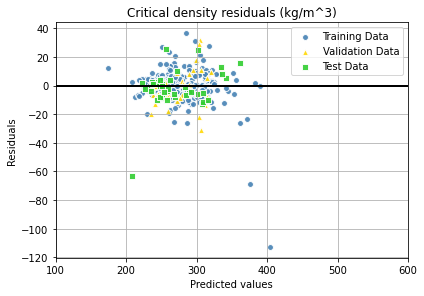

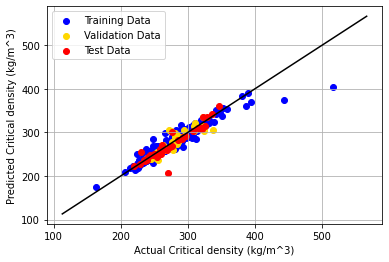

In [107]:
create_residuals_plot(rho_train_vals ,rho_train_pred,
                      rho_valid_vals ,rho_valid_pred,
                      rho_test_vals,rho_test_pred,
                      'Critical density residuals (kg/m^3)',100,600)

create_correlation_plot(rho_train_vals ,rho_train_pred,
                        rho_valid_vals ,rho_valid_pred,
                        rho_test_vals,rho_test_pred,
                        'Critical density (kg/m^3)',ranges['DMIN']-50,ranges['DMAX']+50)

# Derived critical pressure results (MPa)

In [63]:
# Derive Pcrit from the ratio
Pcrit2_train_vals = []
Pcrit2_train_pred = []

Pcrit2_valid_vals = []
Pcrit2_valid_pred = []

Pcrit2_test_vals = []
Pcrit2_test_pred = []

for i in range(y_train.shape[0]):
    Pcrit2_train_vals.append(1/(TP_train_vals[i]/Tcrit_train_vals[i]))
    Pcrit2_train_pred.append(1/(TP_train_pred[i]/Tcrit_train_pred[i]))
    
for i in range(y_val.shape[0]):
    Pcrit2_valid_vals.append(1/(TP_valid_vals[i]/Tcrit_valid_vals[i]))
    Pcrit2_valid_pred.append(1/(TP_valid_pred[i]/Tcrit_valid_pred[i]))
    
for j in range(y_test.shape[0]):
    Pcrit2_test_vals.append(1/(TP_test_vals[j]/Tcrit_test_vals[j]))
    Pcrit2_test_pred.append(1/(TP_test_pred[j]/Tcrit_test_pred[j]))
    
Pcrit2_train_vals = np.asarray(Pcrit2_train_vals)
Pcrit2_train_pred = np.asarray(Pcrit2_train_pred)

Pcrit2_valid_vals = np.asarray(Pcrit2_valid_vals)
Pcrit2_valid_pred = np.asarray(Pcrit2_valid_pred)

Pcrit2_test_vals = np.asarray(Pcrit2_test_vals)
Pcrit2_test_pred = np.asarray(Pcrit2_test_pred)

print('Derived Critical Pressure: R^2 train: %.3f, val: %.3f, test: %.3f' %
       (r2_score( Pcrit2_train_vals,Pcrit2_train_pred),
        r2_score( Pcrit2_valid_vals,Pcrit2_valid_pred),
        r2_score(Pcrit2_test_vals,Pcrit2_test_pred)))

Derived Critical Pressure: R^2 train: 0.929, val: 0.831, test: 0.872


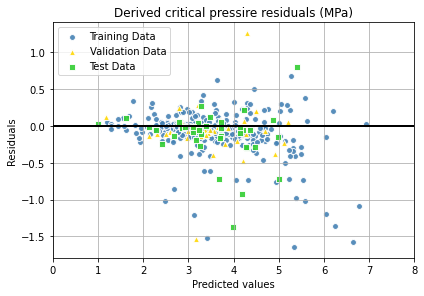

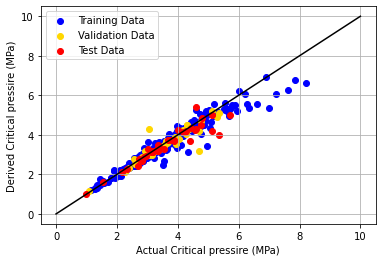

In [117]:
create_residuals_plot(Pcrit2_train_vals,Pcrit2_train_pred,
                      Pcrit2_valid_vals,Pcrit2_valid_pred,
                      Pcrit2_test_vals,Pcrit2_test_pred,
                      'Derived critical pressire residuals (MPa)',0,8)

create_correlation_plot(Pcrit2_train_vals,Pcrit2_train_pred,
                        Pcrit2_valid_vals,Pcrit2_valid_pred,
                        Pcrit2_test_vals,Pcrit2_test_pred,
                        'Critical pressire (MPa)',ranges['PMIN']-1,ranges['PMAX']+3)

In [110]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("my_best_ANN_model.h5")


# Reload the model to calculate RMSE scores

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [5]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("my_best_ANN_model.h5")

# summarize model.
reconstructed_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 192)               7872      
_________________________________________________________________
dense_1 (Dense)              (None, 384)               74112     
_________________________________________________________________
dropout (Dropout)            (None, 384)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1925      
Total params: 83,909
Trainable params: 83,909
Non-trainable params: 0
_________________________________________________________________


# Make sure overall R^2 scores are the same as those of the original model

In [19]:
from sklearn.metrics import r2_score
y_train_pred = reconstructed_model.predict(x_train)
y_val_pred = reconstructed_model.predict(x_val)
y_test_pred = reconstructed_model.predict(x_test)

print('R^2 train: %.3f, val: %.3f, test: %.3f' %
       (r2_score(y_train,y_train_pred),
        r2_score(y_val,y_val_pred),
        r2_score(y_test, y_test_pred)))

R^2 train: 0.939, val: 0.883, test: 0.914


# Calculate the overall RMSE score for all 5 phase change properties 

In [20]:
from sklearn.metrics import mean_squared_error

print('RMSE train: %.3f, val: %.3f, test: %.3f' % (
        mean_squared_error(y_train,y_train_pred,squared=False),
        mean_squared_error(y_val,y_val_pred,squared=False),
        mean_squared_error(y_test, y_test_pred,squared=False)))

RMSE train: 8.746, val: 12.732, test: 10.428


# Boiling point RMSE

In [22]:
BP_train_vals = y_train[:,0]
BP_train_pred = y_train_pred[:,0]

BP_valid_vals = y_val[:,0]
BP_valid_pred = y_val_pred[:,0]

BP_test_vals = y_test[:,0]
BP_test_pred = y_test_pred[:,0]


print('Boiling point: RMSE train: %.3f, val: %.3f, test: %.3f' % (
        mean_squared_error(BP_train_vals,BP_train_pred,squared=False),
        mean_squared_error(BP_valid_vals,BP_valid_pred,squared=False),
        mean_squared_error(BP_test_vals,BP_test_pred,squared=False)))

Boiling point: RMSE train: 7.889, val: 10.994, test: 9.703


# Critical pressure RMSE

In [31]:
Pcrit_train_vals = y_train[:,1]
Pcrit_train_pred = y_train_pred[:,1]

Pcrit_valid_vals = y_val[:,1]
Pcrit_valid_pred = y_val_pred[:,1]

Pcrit_test_vals = y_test[:,1]
Pcrit_test_pred = y_test_pred[:,1]

print('Critical pressure: RMSE train: %.3f, val: %.3f, test: %.3f' % (
        mean_squared_error(Pcrit_train_vals,Pcrit_train_pred,squared=False),
        mean_squared_error(Pcrit_valid_vals,Pcrit_valid_pred,squared=False),
        mean_squared_error(Pcrit_test_vals,Pcrit_test_pred,squared=False)))

Critical pressure: RMSE train: 0.471, val: 0.449, test: 0.479


# Critical temperature RMSE

In [26]:
Tcrit_train_vals = y_train[:,2]
Tcrit_train_pred = y_train_pred[:,2]

Tcrit_valid_vals = y_val[:,2]
Tcrit_valid_pred = y_val_pred[:,2]

Tcrit_test_vals =  y_test[:,2]
Tcrit_test_pred = y_test_pred[:,2]


print('Critical temperature: RMSE train: %.3f, val: %.3f, test: %.3f' % (
        mean_squared_error(Tcrit_train_vals,Tcrit_train_pred,squared=False),
        mean_squared_error(Tcrit_valid_vals,Tcrit_valid_pred,squared=False),
        mean_squared_error(Tcrit_test_vals,Tcrit_test_pred,squared=False)))

Critical temperature: RMSE train: 10.927, val: 17.412, test: 14.369


# Ratio of critical temperature to critical pressure RMSE

In [27]:
TP_train_vals = y_train[:,3]
TP_train_pred = y_train_pred[:,3]

TP_valid_vals = y_val[:,3]
TP_valid_pred = y_val_pred[:,3]

TP_test_vals = y_test[:,3]
TP_test_pred = y_test_pred[:,3]

print('Tcrit/Pcrit: RMSE train: %.3f, val: %.3f, test: %.3f' % (
        mean_squared_error(TP_train_vals,TP_train_pred,squared=False),
        mean_squared_error(TP_valid_vals,TP_valid_pred,squared=False),
        mean_squared_error(TP_test_vals,TP_test_pred,squared=False)))

Tcrit/Pcrit: RMSE train: 13.327, val: 21.780, test: 14.059


# Critical density RMSE

In [28]:
rho_train_vals = y_train[:,4]
rho_train_pred = y_train_pred[:,4]

rho_valid_vals = y_val[:,4]
rho_valid_pred = y_val_pred[:,4]

rho_test_vals = y_test[:,4]
rho_test_pred = y_test_pred[:,4]

print('Critical density: RMSE train: %.3f, val: %.3f, test: %.3f' % (
        mean_squared_error(rho_train_vals,rho_train_pred,squared=False),
        mean_squared_error(rho_valid_vals,rho_valid_pred,squared=False),
        mean_squared_error(rho_test_vals,rho_test_pred,squared=False)))

Critical density: RMSE train: 11.118, val: 13.024, test: 13.531


# Derived critical pressure RMSE

In [30]:
# Derive Pcrit from the ratio
Pcrit2_train_vals = []
Pcrit2_train_pred = []

Pcrit2_valid_vals = []
Pcrit2_valid_pred = []

Pcrit2_test_vals = []
Pcrit2_test_pred = []

for i in range(y_train.shape[0]):
    Pcrit2_train_vals.append(1/(TP_train_vals[i]/Tcrit_train_vals[i]))
    Pcrit2_train_pred.append(1/(TP_train_pred[i]/Tcrit_train_pred[i]))
    
for i in range(y_val.shape[0]):
    Pcrit2_valid_vals.append(1/(TP_valid_vals[i]/Tcrit_valid_vals[i]))
    Pcrit2_valid_pred.append(1/(TP_valid_pred[i]/Tcrit_valid_pred[i]))
    
for j in range(y_test.shape[0]):
    Pcrit2_test_vals.append(1/(TP_test_vals[j]/Tcrit_test_vals[j]))
    Pcrit2_test_pred.append(1/(TP_test_pred[j]/Tcrit_test_pred[j]))
    
Pcrit2_train_vals = np.asarray(Pcrit2_train_vals)
Pcrit2_train_pred = np.asarray(Pcrit2_train_pred)

Pcrit2_valid_vals = np.asarray(Pcrit2_valid_vals)
Pcrit2_valid_pred = np.asarray(Pcrit2_valid_pred)

Pcrit2_test_vals = np.asarray(Pcrit2_test_vals)
Pcrit2_test_pred = np.asarray(Pcrit2_test_pred)


print('Derived Critical Pressure: RMSE train: %.3f, val: %.3f, test: %.3f' % (
        mean_squared_error(Pcrit2_train_vals,Pcrit2_train_pred,squared=False),
        mean_squared_error(Pcrit2_valid_vals,Pcrit2_valid_pred,squared=False),
        mean_squared_error(Pcrit2_test_vals,Pcrit2_test_pred,squared=False)))

Derived Critical Pressure: RMSE train: 0.306, val: 0.378, test: 0.366
